# Testing the 'Flow Matching in 100 LOC'-code and augmenting it with Bayesian Methods

In [1]:
import torch
import torch.nn as nn
from torch import Tensor
from torch.distributions import Normal

import sys
sys.path.append('./src/')
sys.path.append('./src/models/')

from cond_CFM import CNF, FlowMatchingLoss

import numpy as np
import normflows as nf
import os
from tqdm import tqdm
from typing import *
from zuko.utils import odeint
from scipy.special import kl_div
from scipy.stats import wasserstein_distance

from models.custom_linear_flipout import custom_LinearFlipout as LinearFlipout, Flipout_Dropout, LinearDropout
from bayesian_torch.layers.dropout import Dropout
from bayesian_torch.layers.batchnorm import BatchNorm1dLayer

from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
from src.utils import *
from src.dataloader import *
from src.plot_util import *

In [3]:
def mkdir(save_dir):
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    return save_dir

def smooth(x, kernel_size=5):
    if kernel_size == 1:
        return x
    else:
        assert kernel_size % 2 != 0
        x_shape = x.shape
        x_tmp = np.array([x[i:x_shape[0]-kernel_size+i+1] for i in range(kernel_size)])
        edge1 = x[:int((kernel_size-1)/2)]
        edge2 = x[-int((kernel_size-1)/2):]
        x_out = np.concatenate((edge1, np.mean(x_tmp, 0),edge2),0)
        assert x_shape == x_out.shape
        return x_out #np.mean(np.array(x).reshape(-1, kernel_size),1)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [5]:
approximate_gaussian_inference = True
c_factor = 1

if approximate_gaussian_inference:
    save_dir = mkdir(f'./models/CFM_VIB_k{c_factor}')
else:
    save_dir = mkdir('./models/CFM/')

In [6]:
#######################
### Define the data ###
#######################

from dataloader import *

data_dim = 2 #5
save_as_try = 0
n_samples = 1000
save_dir = mkdir(mkdir(save_dir + f'/donut_{data_dim}d/')+f'{n_samples}pts/')

data_path = './data/' 

donut_args = {'u_mean':0, 'u_sigma':1, 'r_mean':4, 'r_sigma':1}
sampler = multidim_sampler(data_dim, "donut", save_path = data_path, **donut_args)

full_data = sampler.sample_data(n_samples, save_as_try = save_as_try)
test_data = sampler.sample_data(n_samples*10)

n_batches = 10
batch_size = n_samples//n_batches
dataloader = torch.utils.data.DataLoader(full_data, batch_size=batch_size, shuffle=True, num_workers=10, pin_memory=True, persistent_workers=True)
dataloader_test = torch.utils.data.DataLoader(test_data, batch_size=len(test_data), shuffle=True, num_workers=10, pin_memory=True, persistent_workers=True)

bins=np.linspace(-7,7,100)
H,_,_ =  np.histogram2d(test_data[:,0], test_data[:,1], bins=bins)

In [7]:
########################
### Define the Model ###
########################
p = 0
n_nodes = 32
n_layers = 3

if approximate_gaussian_inference:
    if p != 0:
        model = CNF(data_dim, conds = 0, hidden_features=[n_nodes] * n_layers, layer = Flipout_Dropout, layer_kwargs={'p': p})
    else:
        model = CNF(data_dim, conds = 0, hidden_features=[n_nodes] * n_layers, layer = LinearFlipout)

else:
    if p != 0:
        model = CNF(data_dim, conds = 0, hidden_features=[n_nodes] * n_layers, layer = LinearDropout,  layer_kwargs={'p': p})
    else:
        model = CNF(data_dim, hidden_features=[n_nodes] * n_layers)
        
model.to(device)

for layer in model.modules():
    if isinstance(layer, LinearFlipout):
        layer._dnn_to_bnn_flag = True
        layer.auto_sample = False 


In [8]:
#####################
### Training Loop ###
#####################

train = True
lr = 1e-3
lr_decay = 1#0.9995
weight_decay = 0

epochs = 5000 #20000
ep_start = 0 #0

if train:
    cfm_loss = FlowMatchingLoss(model)
    optim = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, lr_decay)
    model.train()

    if ep_start == 0:
        loss_hist, loss_hist_KLD, loss_hist_test, loss_hist_test_ep, nlog_likl_hist, kl_div_hist, w1_hist = np.array([]), np.array([]), np.array([]), np.array([]), np.array([]),  np.array([]),  np.array([])

    for ep in tqdm(range(ep_start, ep_start+epochs)):
        optim.zero_grad()
        
        for x in dataloader:
            optim.zero_grad()
            x = x.to(device)
            
            for layer in model.modules():
                if hasattr(layer, 'sample_weights'):
                    layer.sample_weights()

            # Compute loss
            loss_orig = cfm_loss(x, None)
            kl_loss = torch.nan_to_num(torch.sum(torch.tensor([layer.kl_loss() for layer in model.modules() 
                                                                if isinstance(layer, LinearFlipout)],  device=device))/len(x))
            
            loss = loss_orig #+ c_factor*kl_loss

            # Do backprop and optimizer step
            if ~(torch.isnan(loss) | torch.isinf(loss)):
                loss.backward()
                optim.step()
                scheduler.step()
            
        # Log loss
        loss_hist = np.append(loss_hist, loss_orig.to('cpu').data.numpy())
        loss_hist_KLD = np.append(loss_hist_KLD, kl_loss.to('cpu').data.numpy())

        if ep%10 == 0:
            loss_test, nlog_likl = 0, 0
            for x in dataloader_test:
                x = x.to(device)
                loss_test += cfm_loss(x, None)*len(x)
                nlog_likl -= torch.sum(model.log_prob(x,None))
                
            z = torch.randn(n_samples*10, data_dim).to(device)
            generated_data = model.decode(z, cond=None).detach().cpu().numpy()
            H_gen,_,_ =  np.histogram2d(generated_data[:,0], generated_data[:,1], bins=bins)
            w1 = wasserstein_distance(H.flatten(), H_gen.flatten())
            kl_div_test = np.sum(np.nan_to_num(kl_div(H, H_gen), 0, 0, 0))

            loss_hist_test = np.append(loss_hist_test, loss_test.to('cpu').data.numpy()/len(dataloader_test.dataset))
            loss_hist_test_ep= np.append(loss_hist_test_ep, ep)
            nlog_likl_hist = np.append(nlog_likl_hist, nlog_likl.to('cpu').data.numpy()/len(dataloader_test.dataset))
            kl_div_hist = np.append(kl_div_hist, kl_div_test)
            w1_hist = np.append(w1_hist, w1)

        if ep%5000 == 0:
            torch.save(model.state_dict(), save_dir + f"model_{ep}.pth")

    torch.save(model.state_dict(), save_dir + f"model_{ep}.pth")

    with open(save_dir + f'loss_hist_{ep}.npy', 'wb') as f:
        np.save(f, loss_hist)
    with open(save_dir + f'loss_hist_KLD_{ep}.npy', 'wb') as f:
        np.save(f, loss_hist_KLD)
    with open(save_dir + f'loss_hist_test_{ep}.npy', 'wb') as f:
        np.save(f, loss_hist_test)
    with open(save_dir + f'loss_hist_test_ep_{ep}.npy', 'wb') as f:
        np.save(f, loss_hist_test_ep)
    with open(save_dir + f'nlog_likl_hist_{ep}.npy', 'wb') as f:
        np.save(f, nlog_likl_hist)

    model.eval()

else:
    ep = epochs-1

    with open(save_dir + f'loss_hist_{ep}.npy', 'rb') as f:
        loss_hist = np.load(f)
    with open(save_dir + f'loss_hist_KLD_{ep}.npy', 'rb') as f:
        loss_hist_KLD =  np.load(f)
    with open(save_dir + f'loss_hist_test_{ep}.npy', 'rb') as f:
        loss_hist_test =  np.load(f)
    with open(save_dir + f'loss_hist_test_ep_{ep}.npy', 'rb') as f:
        loss_hist_test_ep =  np.load(f)
    with open(save_dir + f'nlog_likl_hist_{ep}.npy', 'rb') as f:
        nlog_likl_hist =  np.load(f)

    model.load_state_dict(torch.load(save_dir + f"model_{ep}.pth"))
    print('loaded model from ' + save_dir + f"model_{ep}.pth")

    model.eval()

100%|██████████| 5000/5000 [13:34<00:00,  6.14it/s]


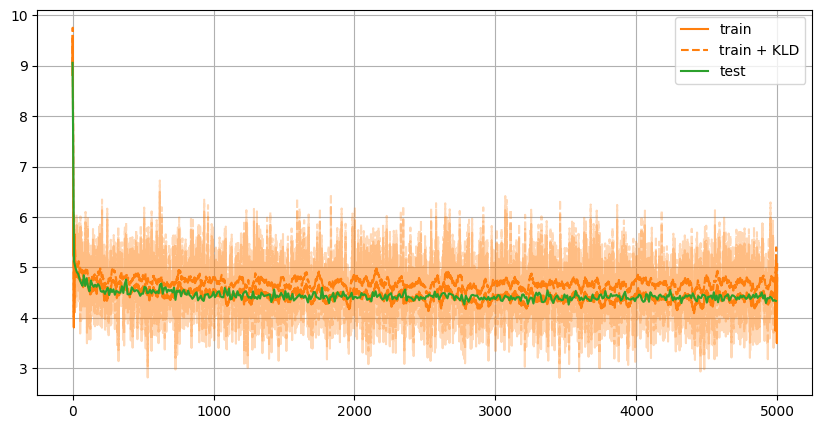

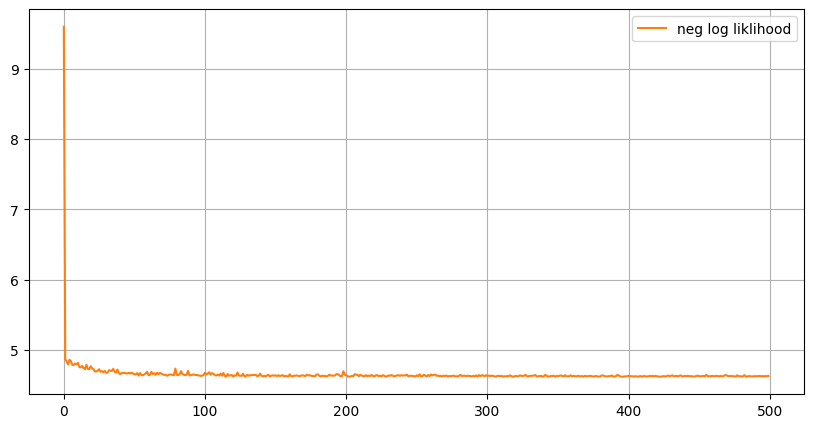

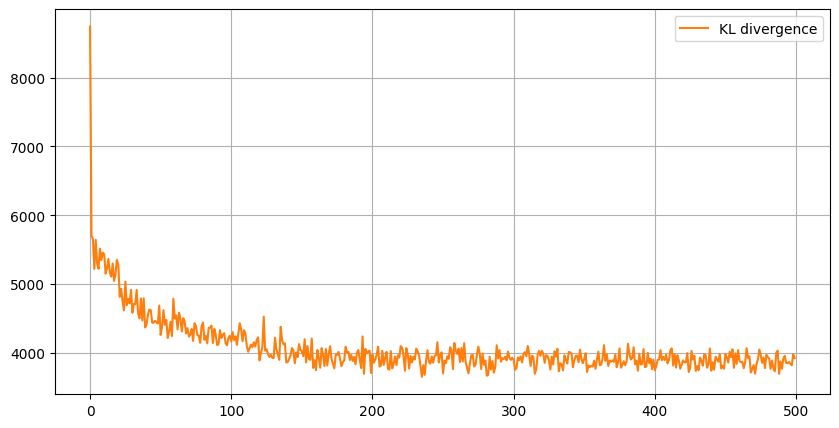

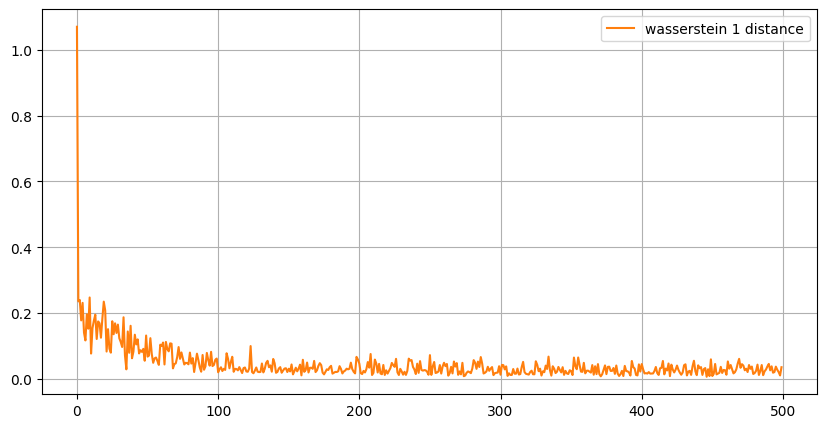

In [9]:
# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(smooth(loss_hist,1), color = 'C1', alpha = 0.3)
plt.plot(smooth(loss_hist,31), color = 'C1', label = 'train')

plt.plot(smooth(loss_hist+c_factor*loss_hist_KLD,1), color = 'C1', linestyle = '--',alpha = 0.3)
plt.plot(smooth(loss_hist+c_factor*loss_hist_KLD,31), color = 'C1', linestyle = '--', label = 'train + KLD')

plt.plot(loss_hist_test_ep, loss_hist_test, color = 'C2', label = 'test')

plt.grid()
plt.legend()
#plt.xlim(0,12500)
#plt.ylim(3,8)
img_outfile = save_dir + f"image_ep{ep}_loss.pdf"
plt.savefig(img_outfile)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(nlog_likl_hist, color = 'C1', label = 'neg log liklihood')
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(kl_div_hist, color = 'C1', label = 'KL divergence')
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(w1_hist, color = 'C1', label = 'wasserstein 1 distance')
plt.grid()
plt.legend()
plt.show()


In [10]:
print(sum(p.numel() for p in model.parameters()))

4932


In [11]:
n_quantile = 16
data_true = cart_to_nsphere(sampler.sample_data(1000000))
quant_list = quantiles(data_true, n_quantile, verbose = False)
quant_list = (np.concatenate((np.asarray([-100]), np.asarray(quant_list[0]), np.asarray([100])), 0),
            np.concatenate((np.asarray([0]), np.asarray(quant_list[1]), np.asarray([2*np.pi])), 0))

data_true = cart_to_nsphere(sampler.sample_data(1000000))
quantvals_true = quantile_values_via_hist(quant_list, data_true)

/beegfs/desy/user/bierings/Bayesiamplify/./src/dataloader.py:7: RuntimeWarning: divide by zero encountered in divide
  out = np.arctan(1/x)


In [12]:
z = torch.randn(1000000, data_dim).to(device)
n_stat_epis = 10

quantvals = []
hist_generated = np.zeros((n_stat_epis, len(bins)-1, len(bins)-1))

for n in tqdm(range(n_stat_epis)):
    if approximate_gaussian_inference:
        for layer in model.modules():
            if isinstance(layer, LinearFlipout):
                layer.auto_sample = False 
                layer.sample_weights()

    generated_data = model.decode(z, cond=None).detach().cpu().numpy()
    quantvals.append(quantile_values_via_hist(quant_list, cart_to_nsphere(generated_data)))
    hist_generated[n], xedges, yedges = np.histogram2d(generated_data[:,0], generated_data[:,1], bins=bins)

quantvals = np.array(quantvals)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:45<00:00,  4.55s/it]


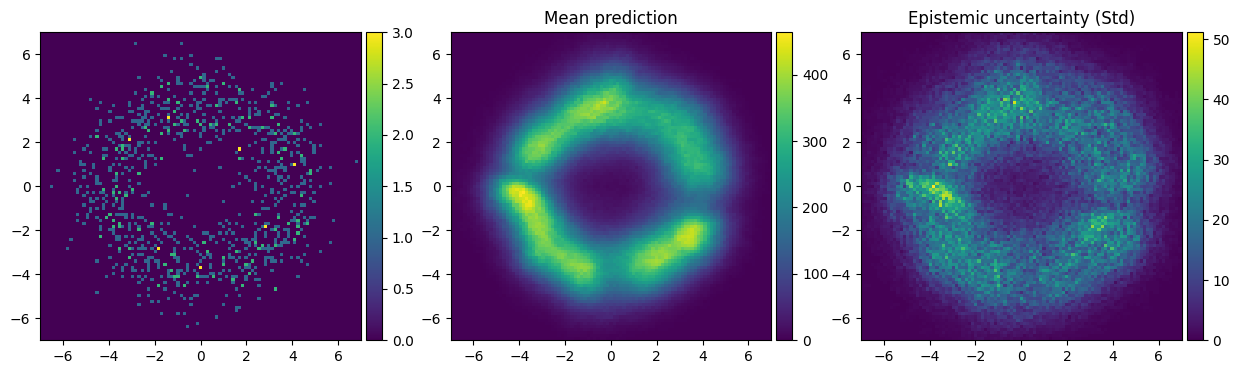

In [13]:
#plot relative uncertainty

fig, ax = plt.subplots(1,3, figsize=(15,4))
X, Y = np.meshgrid(xedges, yedges)

cax = []
for a in ax:
    divider = make_axes_locatable(a)
    cax.append(divider.append_axes('right', size='5%', pad=0.05))

H,_,_ = np.histogram2d(full_data[:,0], full_data[:,1], bins=bins)
im = ax[0].pcolormesh(X, Y, H.T) 
ax[1].set_title('Train Data')
fig.colorbar(im, cax=cax[0], orientation='vertical')

hist_generated_mean = hist_generated.mean(0).T
im = ax[1].pcolormesh(X, Y, hist_generated_mean) 
ax[1].set_title('Mean prediction')
fig.colorbar(im, cax=cax[1], orientation='vertical')

hist_generated_std = hist_generated.std(0).T
im = ax[2].pcolormesh(X, Y, hist_generated_std) 
ax[2].set_title('Epistemic uncertainty (Std)')
fig.colorbar(im, cax=cax[2], orientation='vertical')
img_outfile = save_dir + f"image_ep{ep}_prediction.pdf"
plt.savefig(img_outfile)

In [14]:
bins_data = quant_list

number_pixels = 800 #2000 increase for final plots

quantile_mean_data = quantvals.mean(0)/quantvals_true
quantile_mean_img_data_OG = np.zeros((number_pixels, number_pixels))
quantile_std_data = (quantvals.mean(0)-quantvals_true)/quantvals.std(0)
quantile_std_img_data_OG = np.zeros((number_pixels, number_pixels))

E_min = -6
E_max = 6

for x in range(0, number_pixels):
    for y in range(0, number_pixels):
        X = ((x + 0.0)*(E_max-E_min))/number_pixels+E_min
        Y = ((y + 0.0)*(E_max-E_min))/number_pixels+E_min
        r  = np.sqrt(X**2 + Y**2)
        phi = np.arctan2(X,Y) #+ np.pi
        phi = phi + 2*np.pi*(phi<0).astype(int)
                
        hist_data_temp = np.array([[r,phi]])
        quant_hist_temp, edges = np.histogramdd(sample = hist_data_temp, bins = bins_data, range = None)

        quantile_mean_img_data_OG[x,y] = np.sum(quant_hist_temp*quantile_mean_data)
        quantile_std_img_data_OG[x,y] = np.sum(quant_hist_temp*np.abs(quantile_std_data))

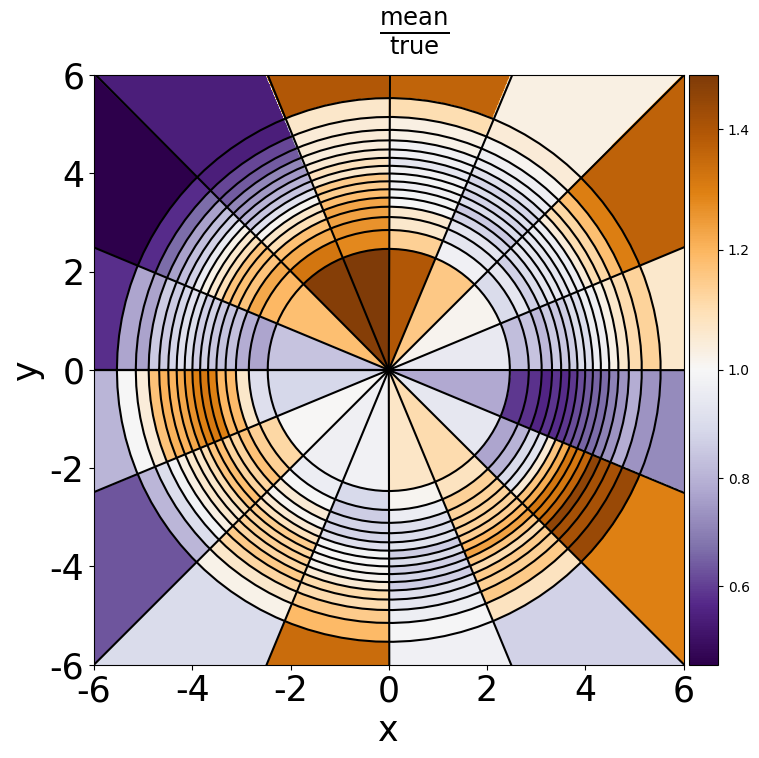

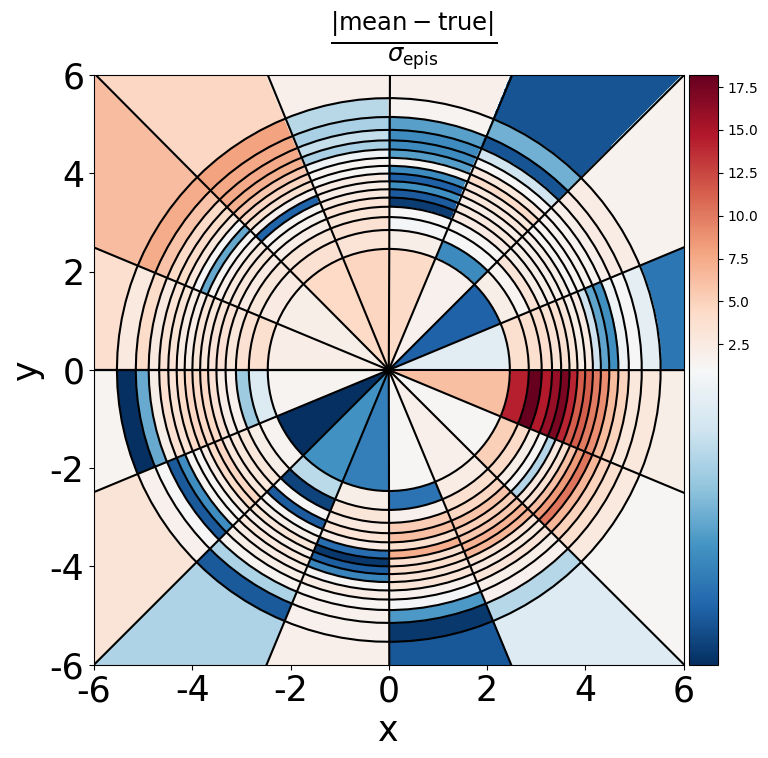

In [15]:
import matplotlib as mpl
import matplotlib.colors as clr

quantile_GAN_img_data = np.copy(quantile_mean_img_data_OG)
quantile_sample_img_data = np.copy(quantile_std_img_data_OG)

font_s = 25

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = clr.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

colors_pos = plt.cm.RdBu_r(np.linspace(0.5, 1, 256))
colors_neg = plt.cm.RdBu_r(np.linspace(1, 0.5, 256))
all_colors = np.vstack((colors_neg, colors_pos))
col_map = clr.LinearSegmentedColormap.from_list('col_map', plt.cm.PuOr(np.linspace(1, 0, 256)))
    #all_colors)

# make the norm:  Note the center is offset so that the land has more
# dynamic range:
divnorm = clr.TwoSlopeNorm(vmin=quantile_GAN_img_data.min(), vcenter=1, vmax=quantile_GAN_img_data.max())
    
figSide = plt.figure(figsize=(8,8))
axS1 = figSide.add_subplot(1,1,1)
pStra = axS1.imshow(quantile_GAN_img_data, norm=divnorm, cmap=col_map)

axS1.set_xticks(np.arange(0, number_pixels+1, number_pixels/6))
axS1.set_xticklabels([-6,-4,-2,0,2,4,6])
axS1.set_yticks(np.arange(0, number_pixels+1, number_pixels/6))
axS1.set_yticklabels([-6,-4,-2,0,2,4,6])
axS1.tick_params(labelsize=font_s) 

divider = make_axes_locatable(axS1)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(pStra, cax=cax)
#cbar.ax.tick_params(labelsize=font_s) 
#collabels = np.concatenate((np.linspace(-1*vmax, vcenter, 3)/vmax + vcenter_OG,
#                            np.linspace(vcenter, vmax, 3)[1:]     + vcenter_OG))
#cbar.ax.set_yticklabels(collabels) 

#figSide.colorbar(pStra)

for r in quant_list[0]:
    a = np.linspace(0, 2*np.pi, 100)
    x = -r*np.cos(a)*number_pixels/(E_max-E_min) + number_pixels/2
    y = r*np.sin(a)*number_pixels/(E_max-E_min) + number_pixels/2
    axS1.plot(x,y, color='k')

for p in quant_list[1]:
    r = np.linspace(0, 20, 20)
    x = -r*np.cos(p)*number_pixels/(E_max-E_min) + number_pixels/2
    y = r*np.sin(p)*number_pixels/(E_max-E_min) + number_pixels/2
    axS1.plot(x,y, color='k')   

x = r*np.cos(np.pi)*number_pixels/(E_max-E_min) + number_pixels/2
y = r*np.sin(np.pi)*number_pixels/(E_max-E_min) + number_pixels/2
axS1.plot(x,y, color='k', label='quantiles')   

axS1.set_xlim([0, number_pixels])
axS1.set_ylim([0, number_pixels])

#axS1.legend()
axS1.set_xlabel('x', fontsize=font_s)
axS1.set_ylabel('y', fontsize=font_s)
figSide.suptitle(r'$\frac{\mathrm{mean}}{\mathrm{true}}$' , fontsize=font_s)
plt.subplots_adjust(left=0.1, right=0.88, top=0.96, bottom=0.10)
        
img_outfile = save_dir + f"image_ep{ep}_mean_radial.pdf"
plt.savefig(img_outfile)

##############################################################################################################################################################################################
##############################################################################################################################################################################################
##############################################################################################################################################################################################

divnorm = clr.TwoSlopeNorm(vmin=quantile_sample_img_data.min(), vcenter=1, vmax=quantile_sample_img_data.max())
col_map = clr.LinearSegmentedColormap.from_list('col_map',  plt.cm.RdBu(np.linspace(1, 0, 256)))

figSide = plt.figure(figsize=(8,8))
axS1 = figSide.add_subplot(1,1,1)
pStra = axS1.imshow(quantile_sample_img_data, norm=divnorm, cmap=col_map)

axS1.set_xticks(np.arange(0, number_pixels+1, number_pixels/6))
axS1.set_xticklabels([-6,-4,-2,0,2,4,6])
axS1.set_yticks(np.arange(0, number_pixels+1, number_pixels/6))
axS1.set_yticklabels([-6,-4,-2,0,2,4,6])
axS1.tick_params(labelsize=font_s) 

divider = make_axes_locatable(axS1)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(pStra, cax=cax)

for r in quant_list[0]:
    a = np.linspace(0, 2*np.pi, 100)
    x = -r*np.cos(a)*number_pixels/(E_max-E_min) + number_pixels/2
    y = r*np.sin(a)*number_pixels/(E_max-E_min) + number_pixels/2
    axS1.plot(x,y, color='k')

for p in quant_list[1]:
    r = np.linspace(0, 20, 20)
    x = -r*np.cos(p)*number_pixels/(E_max-E_min) + number_pixels/2
    y = r*np.sin(p)*number_pixels/(E_max-E_min) + number_pixels/2
    axS1.plot(x,y, color='k')   

x = r*np.cos(np.pi)*number_pixels/(E_max-E_min) + number_pixels/2
y = r*np.sin(np.pi)*number_pixels/(E_max-E_min) + number_pixels/2
axS1.plot(x,y, color='k', label='quantiles')   

axS1.set_xlim([0, number_pixels])
axS1.set_ylim([0, number_pixels])

#axS1.legend()
axS1.set_xlabel('x', fontsize=font_s)
axS1.set_ylabel('y', fontsize=font_s)
figSide.suptitle(r'$\frac{|\mathrm{mean}-\mathrm{true}|}{\sigma_\mathrm{epis}}$' , fontsize=font_s)
plt.subplots_adjust(left=0.1, right=0.88, top=0.96, bottom=0.10)

img_outfile = save_dir + f"image_ep{ep}_sigma_radial.pdf"
plt.savefig(img_outfile)

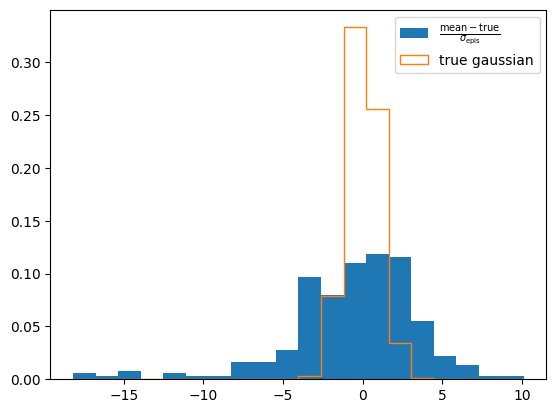

In [18]:
_,b,_, = plt.hist(quantile_std_data.flatten(), density = True, label = r'$\frac{\mathrm{mean}-\mathrm{true}}{\sigma_\mathrm{epis}}$', bins = 20)
_ = plt.hist(np.random.normal(0,1,1000000), density = True, bins = b, histtype='step', label = 'true gaussian')
plt.legend()

In [ ]:
# add up all sigmas